In [123]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
import torch.nn.functional as F
from torch.utils.data import Subset
import cv2
import torchvision.transforms.functional as TF
from torchvision.transforms import InterpolationMode
from torch.utils.data import Dataset
import copy
import math



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_loc = "drive/MyDrive/rotating_gs"
model_loc = "drive/MyDrive"

In [124]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [125]:
train_data = np.load(f"{data_loc}/train.npz")
val_data = np.load(f"{data_loc}/val.npz")
test_data = np.load(f"{data_loc}/test.npz")

# Visualize Data

In [126]:
print(f"Size of train densities: {train_data['densities'].shape}")
print(f"Size of val densities: {val_data['densities'].shape}")
print(f"Size of test densities: {test_data['densities'].shape}")
print()
print(f"Size of train phase gradients: {train_data['phase_gradients'].shape}")
print(f"Size of val phase gradients: {val_data['phase_gradients'].shape}")
print(f"Size of test phase gradients: {test_data['phase_gradients'].shape}")
print()


Size of train densities: (1008, 200, 200)
Size of val densities: (336, 200, 200)
Size of test densities: (336, 200, 200)

Size of train phase gradients: (1008, 2, 200, 200)
Size of val phase gradients: (336, 2, 200, 200)
Size of test phase gradients: (336, 2, 200, 200)



Text(0.5, 0.98, 'Training Example')

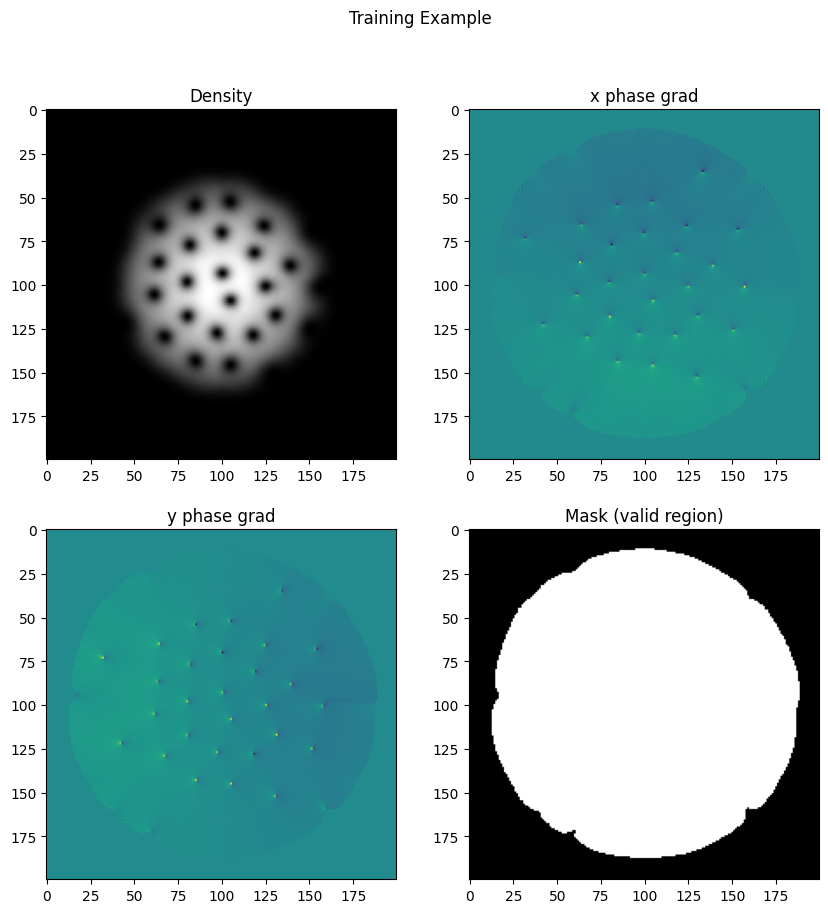

In [127]:
# Visualize an example
idx = 1
fig, axes = plt.subplots(2, 2, figsize = (10, 10))
axes[0, 0].imshow(train_data['densities'][idx], cmap='gray')
axes[0, 1].imshow(train_data['phase_gradients'][idx, 0])
axes[1, 0].imshow(train_data['phase_gradients'][idx, 1])
axes[1, 1].imshow(1 - train_data['masks'][idx, 0], cmap = 'gray')

axes[0, 0].set_title("Density")
axes[0, 1].set_title("x phase grad")
axes[1, 0].set_title("y phase grad")
axes[1, 1].set_title("Mask (valid region)")

plt.suptitle("Training Example")

# Custom Datasets/Dataloaders

In [128]:
class BecDataset(Dataset):
    def __init__(self, densities, phase_grads, masks, log_eps=1e-9):
        """
        densities: (N, W, W)
        phase_grads: (N, 2, W, W)
        masks: (N, 2, W, W)
        log_eps: added before log() for numerical stability
        """
        self.densities = torch.tensor(densities).float().unsqueeze(1)
        self.phase_grads = torch.tensor(phase_grads).float()
        self.masks = torch.tensor(masks).float()
        self.log_eps = log_eps

    def __len__(self):
        return self.densities.size(0)

    def __getitem__(self, idx):
        density = self.densities[idx]
        density = torch.log(density + self.log_eps)
        phase_grad = self.phase_grads[idx]
        mask = self.masks[idx]
        return density, phase_grad, mask

train_dataset = BecDataset(train_data['densities'], train_data['phase_gradients'], train_data['masks'])
val_dataset = BecDataset(val_data['densities'], val_data['phase_gradients'], val_data['masks'])
test_dataset = BecDataset(test_data['densities'], test_data['phase_gradients'], test_data['masks'])

In [129]:
# Create corresponding dataloaders
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers = 2)
val_loader = DataLoader(val_dataset, num_workers = 2)
test_loader = DataLoader(test_dataset, num_workers = 2)

# UNET Definition

In [130]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels, momentum = 0.2),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels, momentum = 0.2),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True, add_skip = True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        self.add_skip = add_skip
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        if self.add_skip:
            x = torch.cat([x2, x1], dim=1)
            #print(f"dim after concatenation: {x.shape}")
        else:
            x = x1
        #print(f"Running conv2d with {self.conv.double_conv[0].in_channels} in_channels, {self.conv.double_conv[-3].out_channels} out_channels")
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, channels, bilinear=True, add_skip = True, out_channels = 1, wrap_angles = False, verbose=False):
        super(UNet, self).__init__()
        self.channels = channels
        self.bilinear = bilinear
        self.verbose = verbose
        self.wrap_angles = wrap_angles

        self.inc = DoubleConv(channels[0], channels[1])
        if add_skip:
            #Repeat the final layer to add a skip connection in that layer
            self.downs = nn.ModuleList([Down(channels[i], channels[i+1]) for i in range(1, len(channels)-1)] +
                                       [Down(channels[-1], channels[-1])])
            self.ups = nn.ModuleList([Up(2*channels[i+1], channels[i], bilinear, add_skip) for i in range(len(channels)-2, 0, -1)] +
                                     [Up(2* channels[1], channels[1], bilinear, add_skip)])
        else:
            self.downs = nn.ModuleList([Down(channels[i], channels[i+1]) for i in range(1, len(channels)-1)])
            self.ups = nn.ModuleList([Up(channels[i+1], channels[i], bilinear, add_skip) for i in range(len(channels)-2, 0, -1)])
        self.outc = OutConv(channels[1], out_channels)

    def forward(self, x):
        x_stages = [self.inc(x)]
        if self.verbose:
            print(f"x1 shape: {x_stages[-1].shape}")

        for down in self.downs:
            x_stages.append(down(x_stages[-1]))
            if self.verbose:
                print(f"Down stage shape: {x_stages[-1].shape}")

        x = x_stages.pop()
        for up in self.ups:
            x = up(x, x_stages.pop())
            if self.verbose:
                print(f"Up stage shape: {x.shape}")

        x = self.outc(x)
        if self.verbose:
            print(f"Output shape: {x.shape}")

        #Make between -pi and pi
        if self.wrap_angles:
            x = -F.relu(x + torch.pi) + 2*torch.pi
            x = F.relu(x) - torch.pi
        return x

In [131]:
#Example usage, showing the channel sizes
unet_8 = UNet(channels = [1, 8, 16, 32, 64, 128, 256, 512], out_channels = 2, verbose = True)
dataiter = iter(train_loader)
images, labels, masks = next(dataiter)
print(images.shape)

output = unet_8(images);

torch.Size([8, 1, 200, 200])
x1 shape: torch.Size([8, 8, 200, 200])
Down stage shape: torch.Size([8, 16, 100, 100])
Down stage shape: torch.Size([8, 32, 50, 50])
Down stage shape: torch.Size([8, 64, 25, 25])
Down stage shape: torch.Size([8, 128, 12, 12])
Down stage shape: torch.Size([8, 256, 6, 6])
Down stage shape: torch.Size([8, 512, 3, 3])
Down stage shape: torch.Size([8, 512, 1, 1])
Up stage shape: torch.Size([8, 256, 3, 3])
Up stage shape: torch.Size([8, 128, 6, 6])
Up stage shape: torch.Size([8, 64, 12, 12])
Up stage shape: torch.Size([8, 32, 25, 25])
Up stage shape: torch.Size([8, 16, 50, 50])
Up stage shape: torch.Size([8, 8, 100, 100])
Up stage shape: torch.Size([8, 8, 200, 200])
Output shape: torch.Size([8, 2, 200, 200])


# Training


In [132]:
def apply_prune_masks(model):
    with torch.no_grad():
        for module in model.modules():
            if hasattr(module, "weight_mask"):
                module.weight_orig.mul_(module.weight_mask)


In [133]:
def predict(dataloader, model, device="cpu"):
    """
    Return *torch tensors* for inputs, predictions, ground_truths, masks, and errors.
    """
    model.eval()
    inputs_list = []
    predictions = []
    ground_truths = []
    masks = []
    with torch.no_grad():
        for inputs, targets, mask_batch in dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            mask_batch = mask_batch.to(device)
            preds = model(inputs)

            inputs_list.append(inputs)
            predictions.append(preds)
            ground_truths.append(targets)
            masks.append(mask_batch)

    # Concatenate tensors over batch dimension
    return (
        torch.cat(inputs_list, dim=0),
        torch.cat(predictions, dim=0),
        torch.cat(ground_truths, dim=0),
        torch.cat(masks, dim=0),
    )

def train_model(train_loader, model, loss_fn, optimizer, epochs=10, device="cpu"):

    model.to(device)

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for inputs, targets, masks in train_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            masks = masks.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, targets, masks)
            loss.backward()
            optimizer.step()
            # apply_prune_masks(model) # new

            total_loss += loss.item()

        # Run validation using torch-level predict()
        _, predictions, ground_truths, masks = predict(
            val_loader, model, device=device
        )
        val_loss = loss_fn(predictions, ground_truths, masks).item()

        print(f"Epoch {epoch+1} Train Loss: {total_loss / len(train_loader)}, Val Loss: {val_loss}")

In [134]:
#Custom Loss function
#Ignores losses for masked out regions (mask = 1), as these are
#Low density regions and we don't care whether we get them right or not

def mse_with_mask(outputs, targets, masks, keep_first_dim = False):
    if keep_first_dim:
        return torch.mean(((outputs-targets)**2)*(1-masks), dim = (-1, -2, -3))
    else:
        return torch.mean(((outputs-targets)**2)*(1-masks))

unet_8 = UNet(channels = [1, 8, 16, 32, 64, 128, 256, 512], out_channels = 2)
optimizer = optim.Adam(unet_8.parameters(), lr=1e-3)

train_model(train_loader, unet_8, mse_with_mask, optimizer, epochs=20, device=device)

Epoch 1 Train Loss: 0.011575454809067269, Val Loss: 0.011019377037882805
Epoch 2 Train Loss: 0.005267356879018721, Val Loss: 0.005030306521803141
Epoch 3 Train Loss: 0.004211459785611147, Val Loss: 0.004196262918412685
Epoch 4 Train Loss: 0.0035572429113681354, Val Loss: 0.003987574949860573
Epoch 5 Train Loss: 0.003116135420795116, Val Loss: 0.0038567539304494858
Epoch 6 Train Loss: 0.0028865045372633235, Val Loss: 0.0036193770356476307
Epoch 7 Train Loss: 0.002672944657711519, Val Loss: 0.0025658507365733385
Epoch 8 Train Loss: 0.002484908908612967, Val Loss: 0.002499738708138466
Epoch 9 Train Loss: 0.0023381738601962014, Val Loss: 0.0022323685698211193
Epoch 10 Train Loss: 0.002204528352844396, Val Loss: 0.0023768239188939333
Epoch 11 Train Loss: 0.002082010797624077, Val Loss: 0.002246369607746601
Epoch 12 Train Loss: 0.002023965145261692, Val Loss: 0.002182635711506009
Epoch 13 Train Loss: 0.0019514601500261399, Val Loss: 0.002268166048452258
Epoch 14 Train Loss: 0.001928741628828

# Test Set Evaluation

In [135]:
# Get test predictions
inputs, predictions, truths, masks = predict(test_loader, unet_8, device = device)
errors = mse_with_mask(predictions, truths, masks, keep_first_dim = True)
baseline_mse = errors.mean()

print(f"Error on the testing set: {baseline_mse}")

Error on the testing set: 0.0016463506035506725


In [136]:
# Convert to numpy arrays
inputs = inputs.cpu().numpy()
predictions = predictions.cpu().numpy()
truths = truths.cpu().numpy()
masks = masks.cpu().numpy()
errors = errors.cpu().numpy()

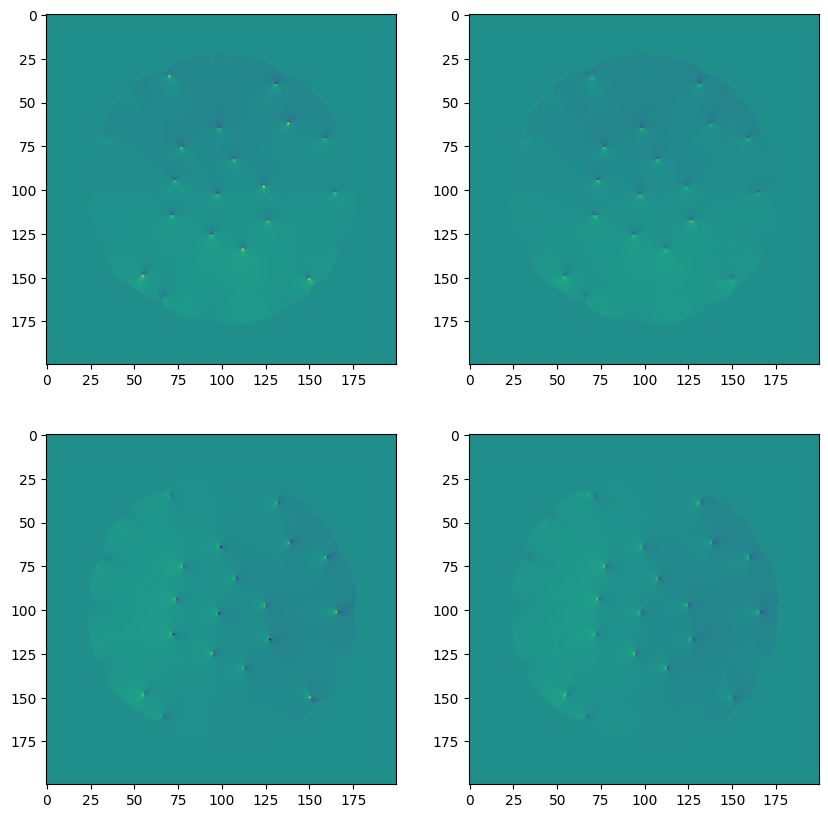

In [137]:
# Visualize a prediction
idx = 1
vmin = truths.min()
vmax = truths.max()
fig, axes = plt.subplots(2, 2, figsize = (10, 10))

axes[0, 0].imshow(truths[idx, 0], vmin = vmin, vmax = vmax)
axes[0, 1].imshow(predictions[idx, 0] * (1 - masks[idx, 0]), vmin = vmin, vmax = vmax)
axes[1, 0].imshow(truths[idx, 1], vmin = vmin, vmax = vmax)
axes[1, 1].imshow(predictions[idx, 1] * (1 - masks[idx, 0]), vmin = vmin, vmax = vmax)

Text(0, 0.5, 'Frequency')

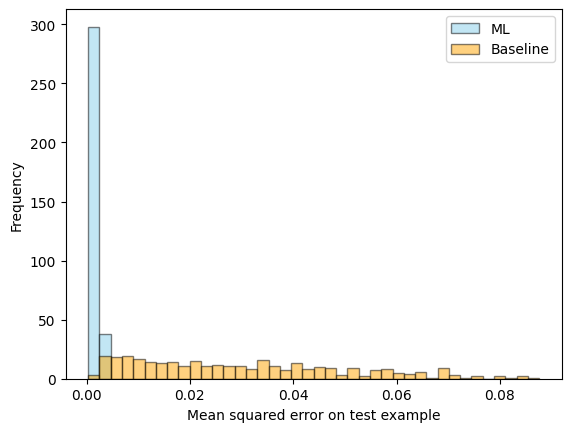

In [138]:
# Histogram of model test set errors and baseline errors.
baseline_errors = np.var(truths, axis = (-1, -2, -3))
all_errors = np.concatenate([errors, baseline_errors])

bin_edges = np.histogram_bin_edges(all_errors, bins=40)
plt.hist(errors, alpha = 0.5, bins = bin_edges, label = "ML", color='skyblue', edgecolor='black')
plt.hist(baseline_errors, alpha = 0.5, bins = bin_edges, label = "Baseline", color='orange', edgecolor='black')
plt.legend()
plt.xlabel("Mean squared error on test example")
plt.ylabel("Frequency")

In [139]:
import torch
import numpy as np
import matplotlib.pyplot as plt

bins = 100

def plot_weight_histogram(model, bins, log_switch):
  eps = 1e-15
  vals = []
  for name, param in model.named_parameters():
      vals.append(param.detach().cpu().numpy().ravel())
  all_vals = np.concatenate(vals)
  all_vals = all_vals[abs(all_vals) > eps]

  mean = np.mean(all_vals)
  std = np.std(all_vals)
  max = np.max(all_vals)
  min = np.min(all_vals)
  print(f"Mean: {mean}, std: {std}, max: {max}, min: {min}")
  log_vals = np.log10(abs(all_vals + eps))

  plt.figure(figsize=(6,4))
  if log_switch:
    plt.hist(log_vals, bins=bins, alpha=0.8, edgecolor='black')
  else:
    plt.hist(all_vals, bins=bins, alpha=0.8, edgecolor='black')

  plt.title('Histogram of model weights (all layers)')
  plt.xlabel('Weight value')
  plt.ylabel('Count')
  plt.grid(True, linestyle=':', alpha=0.5)
  plt.show()

Mean: 0.00018738227663561702, std: 0.019631071016192436, max: 1.2427388429641724, min: -0.4256131947040558


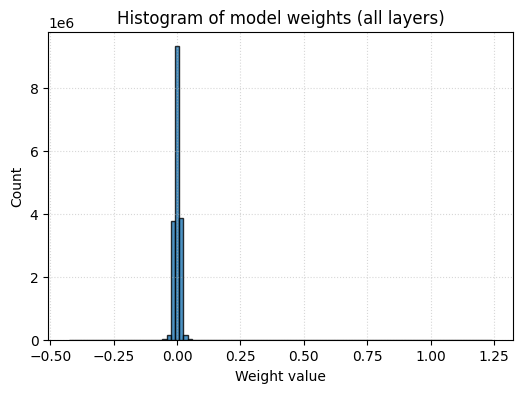

In [140]:
plot_weight_histogram(unet_8, bins, False)

Mean: 0.00018738227663561702, std: 0.019631071016192436, max: 1.2427388429641724, min: -0.4256131947040558


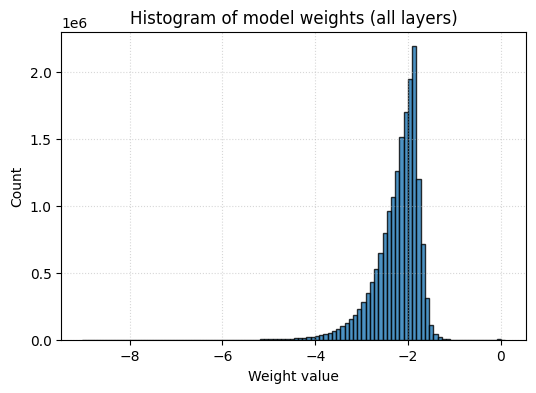

In [141]:
plot_weight_histogram(unet_8, bins, True)

In [142]:
# pruning function

import torch.nn.utils.prune as prune

def prune_global_torch_prune(model, percent):
    parameters_to_prune = []
    for module in model.modules():

        if hasattr(module, 'weight') and module.weight is not None:
            parameters_to_prune.append((module, 'weight'))

    # amount = percent / 100.0

    ## START ##

    desired = percent / 100.0
    total = 0
    zeroed = 0
    for module, name in parameters_to_prune:
        mask = getattr(module, f'{name}_mask', None)
        if mask is None:
            tensor = getattr(module, name).detach()
            total += tensor.numel()
            zeroed += (tensor.abs() == 0).sum().item()
        else:
            total += mask.numel()
            zeroed += (mask == 0).sum().item()
    current = zeroed / total if total > 0 else 0.0
    if desired <= current:
        return 100.0 * current
    amount = (desired - current) / (1.0 - current)

    ## END ##

    prune.global_unstructured(
        parameters_to_prune,
        pruning_method=prune.L1Unstructured,
        amount=amount
    )

    total = 0
    zeroed = 0
    for module, name in parameters_to_prune:
        mask = getattr(module, f'{name}_mask', None)
        if mask is None:
            tensor = getattr(module, name).detach()
            total += tensor.numel()
            zeroed += (tensor.abs() == 0).sum().item()
        else:
            total += mask.numel()
            zeroed += (mask == 0).sum().item()
    return 100.0 * zeroed / total


In [143]:
# calculate mse, taken from code above and made into a function

def evaluate_mse(model, dataloader, device):
    model.eval()
    with torch.no_grad():
        inputs, predictions, truths, masks = predict(
            dataloader,
            model,
            device=device
        )
        errors = mse_with_mask(
            predictions,
            truths,
            masks,
            keep_first_dim=True
        )
        return errors.mean().item()



In [150]:
# save dense baseline

dense_state = {
    "model": unet_8.state_dict()
}
torch.save(dense_state, "unet_dense.pth")

In [156]:
# perform a sweep through a number of different percentages of weights to prune (prune 50% of weights, 75%, 90%, etc.)

def prune_sweep_and_plot(model, test_loader, device, prune_fn, baseline_mse, percentages, retrain):

  # orig_state = copy.deepcopy(model.state_dict())
  orig_state = copy.deepcopy(dense_state)

  results = []
  # model.load_state_dict(orig_state) # if retraining

  for pct in percentages:

    if not retrain or retrain == 'Iterative':

      model.load_state_dict(orig_state)
      try:
        import torch.nn.utils.prune as prune
        # remove existing masks
        for mod in model.modules():
            for name, _ in list(mod.named_parameters(recurse=False)):
                mask_attr = f"{name}_mask"
                if hasattr(mod, mask_attr):
                    try:
                        prune.remove(mod, name)
                    except Exception:
                        pass
      except Exception:
        pass
      # model.load_state_dict(orig_state)

    actual_pruned = prune_fn(model, pct)

    if retrain == 'Iterative' or retrain == 'Cumulative':
      # apply_prune_masks(model)

      if pct > 0:
        # new optimizer for retraining
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

        # retrain
        train_model(train_loader, model, mse_with_mask, optimizer, epochs=2, device=device)

    mse = evaluate_mse(model, test_loader, device)
    print(f"Pruned requested {pct:.2f}% -> actual {actual_pruned:.2f}% ; MSE = {mse:.6e}\n")
    results.append((pct, actual_pruned, mse))

  # restore original weights
  # model.load_state_dict(orig_state)

  percentages_actual = [r[1] for r in results]
  mses_percent_drop = [(1 - r[2] / baseline_mse) for r in results]

  return results, mses_percent_drop


In [157]:
# copy the model for the three pruning cases

model_no_retrain = UNet(channels = [1, 8, 16, 32, 64, 128, 256, 512], out_channels = 2)
model_no_retrain.load_state_dict(dense_state["model"])
model_no_retrain.to(device)

model_iterative = UNet(channels = [1, 8, 16, 32, 64, 128, 256, 512], out_channels = 2)
model_iterative.load_state_dict(dense_state["model"])
model_iterative.to(device)

model_cumulative = UNet(channels = [1, 8, 16, 32, 64, 128, 256, 512], out_channels = 2)
model_cumulative.load_state_dict(dense_state["model"])
model_cumulative.to(device)

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.2, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(8, eps=1e-05, momentum=0.2, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (downs): ModuleList(
    (0): Down(
      (maxpool_conv): Sequential(
        (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (1): DoubleConv(
          (double_conv): Sequential(
            (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): BatchNorm2d(16, eps=1e-05, momentum=0.2, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
            (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (4): Batch

In [158]:
# run the sweep

sweep_params_no_retrain = [0,40,50,70,80,90]
sweep_params_iterative_retrain = [0,40,50,70,80,90]
sweep_params_cumulative_retrain = [40,90,99,99.9]

results_no_retrain, mses_percent_drop_no_retrain = prune_sweep_and_plot(model_no_retrain, test_loader, device,
                                                    prune_global_torch_prune,
                                                    baseline_mse.item(),
                                                    sweep_params_no_retrain,
                                                    retrain=False)

RuntimeError: Error(s) in loading state_dict for UNet:
	Missing key(s) in state_dict: "inc.double_conv.0.weight", "inc.double_conv.0.bias", "inc.double_conv.1.weight", "inc.double_conv.1.bias", "inc.double_conv.1.running_mean", "inc.double_conv.1.running_var", "inc.double_conv.3.weight", "inc.double_conv.3.bias", "inc.double_conv.4.weight", "inc.double_conv.4.bias", "inc.double_conv.4.running_mean", "inc.double_conv.4.running_var", "downs.0.maxpool_conv.1.double_conv.0.weight", "downs.0.maxpool_conv.1.double_conv.0.bias", "downs.0.maxpool_conv.1.double_conv.1.weight", "downs.0.maxpool_conv.1.double_conv.1.bias", "downs.0.maxpool_conv.1.double_conv.1.running_mean", "downs.0.maxpool_conv.1.double_conv.1.running_var", "downs.0.maxpool_conv.1.double_conv.3.weight", "downs.0.maxpool_conv.1.double_conv.3.bias", "downs.0.maxpool_conv.1.double_conv.4.weight", "downs.0.maxpool_conv.1.double_conv.4.bias", "downs.0.maxpool_conv.1.double_conv.4.running_mean", "downs.0.maxpool_conv.1.double_conv.4.running_var", "downs.1.maxpool_conv.1.double_conv.0.weight", "downs.1.maxpool_conv.1.double_conv.0.bias", "downs.1.maxpool_conv.1.double_conv.1.weight", "downs.1.maxpool_conv.1.double_conv.1.bias", "downs.1.maxpool_conv.1.double_conv.1.running_mean", "downs.1.maxpool_conv.1.double_conv.1.running_var", "downs.1.maxpool_conv.1.double_conv.3.weight", "downs.1.maxpool_conv.1.double_conv.3.bias", "downs.1.maxpool_conv.1.double_conv.4.weight", "downs.1.maxpool_conv.1.double_conv.4.bias", "downs.1.maxpool_conv.1.double_conv.4.running_mean", "downs.1.maxpool_conv.1.double_conv.4.running_var", "downs.2.maxpool_conv.1.double_conv.0.weight", "downs.2.maxpool_conv.1.double_conv.0.bias", "downs.2.maxpool_conv.1.double_conv.1.weight", "downs.2.maxpool_conv.1.double_conv.1.bias", "downs.2.maxpool_conv.1.double_conv.1.running_mean", "downs.2.maxpool_conv.1.double_conv.1.running_var", "downs.2.maxpool_conv.1.double_conv.3.weight", "downs.2.maxpool_conv.1.double_conv.3.bias", "downs.2.maxpool_conv.1.double_conv.4.weight", "downs.2.maxpool_conv.1.double_conv.4.bias", "downs.2.maxpool_conv.1.double_conv.4.running_mean", "downs.2.maxpool_conv.1.double_conv.4.running_var", "downs.3.maxpool_conv.1.double_conv.0.weight", "downs.3.maxpool_conv.1.double_conv.0.bias", "downs.3.maxpool_conv.1.double_conv.1.weight", "downs.3.maxpool_conv.1.double_conv.1.bias", "downs.3.maxpool_conv.1.double_conv.1.running_mean", "downs.3.maxpool_conv.1.double_conv.1.running_var", "downs.3.maxpool_conv.1.double_conv.3.weight", "downs.3.maxpool_conv.1.double_conv.3.bias", "downs.3.maxpool_conv.1.double_conv.4.weight", "downs.3.maxpool_conv.1.double_conv.4.bias", "downs.3.maxpool_conv.1.double_conv.4.running_mean", "downs.3.maxpool_conv.1.double_conv.4.running_var", "downs.4.maxpool_conv.1.double_conv.0.weight", "downs.4.maxpool_conv.1.double_conv.0.bias", "downs.4.maxpool_conv.1.double_conv.1.weight", "downs.4.maxpool_conv.1.double_conv.1.bias", "downs.4.maxpool_conv.1.double_conv.1.running_mean", "downs.4.maxpool_conv.1.double_conv.1.running_var", "downs.4.maxpool_conv.1.double_conv.3.weight", "downs.4.maxpool_conv.1.double_conv.3.bias", "downs.4.maxpool_conv.1.double_conv.4.weight", "downs.4.maxpool_conv.1.double_conv.4.bias", "downs.4.maxpool_conv.1.double_conv.4.running_mean", "downs.4.maxpool_conv.1.double_conv.4.running_var", "downs.5.maxpool_conv.1.double_conv.0.weight", "downs.5.maxpool_conv.1.double_conv.0.bias", "downs.5.maxpool_conv.1.double_conv.1.weight", "downs.5.maxpool_conv.1.double_conv.1.bias", "downs.5.maxpool_conv.1.double_conv.1.running_mean", "downs.5.maxpool_conv.1.double_conv.1.running_var", "downs.5.maxpool_conv.1.double_conv.3.weight", "downs.5.maxpool_conv.1.double_conv.3.bias", "downs.5.maxpool_conv.1.double_conv.4.weight", "downs.5.maxpool_conv.1.double_conv.4.bias", "downs.5.maxpool_conv.1.double_conv.4.running_mean", "downs.5.maxpool_conv.1.double_conv.4.running_var", "downs.6.maxpool_conv.1.double_conv.0.weight", "downs.6.maxpool_conv.1.double_conv.0.bias", "downs.6.maxpool_conv.1.double_conv.1.weight", "downs.6.maxpool_conv.1.double_conv.1.bias", "downs.6.maxpool_conv.1.double_conv.1.running_mean", "downs.6.maxpool_conv.1.double_conv.1.running_var", "downs.6.maxpool_conv.1.double_conv.3.weight", "downs.6.maxpool_conv.1.double_conv.3.bias", "downs.6.maxpool_conv.1.double_conv.4.weight", "downs.6.maxpool_conv.1.double_conv.4.bias", "downs.6.maxpool_conv.1.double_conv.4.running_mean", "downs.6.maxpool_conv.1.double_conv.4.running_var", "ups.0.conv.double_conv.0.weight", "ups.0.conv.double_conv.0.bias", "ups.0.conv.double_conv.1.weight", "ups.0.conv.double_conv.1.bias", "ups.0.conv.double_conv.1.running_mean", "ups.0.conv.double_conv.1.running_var", "ups.0.conv.double_conv.3.weight", "ups.0.conv.double_conv.3.bias", "ups.0.conv.double_conv.4.weight", "ups.0.conv.double_conv.4.bias", "ups.0.conv.double_conv.4.running_mean", "ups.0.conv.double_conv.4.running_var", "ups.1.conv.double_conv.0.weight", "ups.1.conv.double_conv.0.bias", "ups.1.conv.double_conv.1.weight", "ups.1.conv.double_conv.1.bias", "ups.1.conv.double_conv.1.running_mean", "ups.1.conv.double_conv.1.running_var", "ups.1.conv.double_conv.3.weight", "ups.1.conv.double_conv.3.bias", "ups.1.conv.double_conv.4.weight", "ups.1.conv.double_conv.4.bias", "ups.1.conv.double_conv.4.running_mean", "ups.1.conv.double_conv.4.running_var", "ups.2.conv.double_conv.0.weight", "ups.2.conv.double_conv.0.bias", "ups.2.conv.double_conv.1.weight", "ups.2.conv.double_conv.1.bias", "ups.2.conv.double_conv.1.running_mean", "ups.2.conv.double_conv.1.running_var", "ups.2.conv.double_conv.3.weight", "ups.2.conv.double_conv.3.bias", "ups.2.conv.double_conv.4.weight", "ups.2.conv.double_conv.4.bias", "ups.2.conv.double_conv.4.running_mean", "ups.2.conv.double_conv.4.running_var", "ups.3.conv.double_conv.0.weight", "ups.3.conv.double_conv.0.bias", "ups.3.conv.double_conv.1.weight", "ups.3.conv.double_conv.1.bias", "ups.3.conv.double_conv.1.running_mean", "ups.3.conv.double_conv.1.running_var", "ups.3.conv.double_conv.3.weight", "ups.3.conv.double_conv.3.bias", "ups.3.conv.double_conv.4.weight", "ups.3.conv.double_conv.4.bias", "ups.3.conv.double_conv.4.running_mean", "ups.3.conv.double_conv.4.running_var", "ups.4.conv.double_conv.0.weight", "ups.4.conv.double_conv.0.bias", "ups.4.conv.double_conv.1.weight", "ups.4.conv.double_conv.1.bias", "ups.4.conv.double_conv.1.running_mean", "ups.4.conv.double_conv.1.running_var", "ups.4.conv.double_conv.3.weight", "ups.4.conv.double_conv.3.bias", "ups.4.conv.double_conv.4.weight", "ups.4.conv.double_conv.4.bias", "ups.4.conv.double_conv.4.running_mean", "ups.4.conv.double_conv.4.running_var", "ups.5.conv.double_conv.0.weight", "ups.5.conv.double_conv.0.bias", "ups.5.conv.double_conv.1.weight", "ups.5.conv.double_conv.1.bias", "ups.5.conv.double_conv.1.running_mean", "ups.5.conv.double_conv.1.running_var", "ups.5.conv.double_conv.3.weight", "ups.5.conv.double_conv.3.bias", "ups.5.conv.double_conv.4.weight", "ups.5.conv.double_conv.4.bias", "ups.5.conv.double_conv.4.running_mean", "ups.5.conv.double_conv.4.running_var", "ups.6.conv.double_conv.0.weight", "ups.6.conv.double_conv.0.bias", "ups.6.conv.double_conv.1.weight", "ups.6.conv.double_conv.1.bias", "ups.6.conv.double_conv.1.running_mean", "ups.6.conv.double_conv.1.running_var", "ups.6.conv.double_conv.3.weight", "ups.6.conv.double_conv.3.bias", "ups.6.conv.double_conv.4.weight", "ups.6.conv.double_conv.4.bias", "ups.6.conv.double_conv.4.running_mean", "ups.6.conv.double_conv.4.running_var", "outc.conv.weight", "outc.conv.bias". 
	Unexpected key(s) in state_dict: "model". 

In [ ]:
# plot_weight_histogram(unet_8, bins, False)

In [ ]:
# plot the sweep results

def plot_accuracy(sweep_params, mses_percent_drop):

    plt.figure(figsize=(7,3))
    plt.plot(sweep_params, mses_percent_drop, '-bo')
    plt.xlim(left=0)
    plt.xlim(right=100)
    # plt.ylim(bottom=-5)
    plt.xlabel('% of weights pruned')
    plt.ylabel('% accuracy loss')
    plt.title('% Accuracy Loss vs % Weights Pruned')
    plt.grid(True)
    plt.show()

In [ ]:
plot_accuracy(sweep_params_no_retrain, mses_percent_drop_no_retrain)